In [ ]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src import get_represents

from src.plotting_scripts import landtype
from src.plotting_scripts import stackplot
from src.plotting_scripts import rose_plot
from src.plotting_scripts import stacks
from src.plotting_scripts import stat_scatterplot

import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature

In [ ]:
nysm_cats_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")
nysm_cats_df.head()

In [ ]:
# extract wanted info
nysm_cats_df = nysm_cats_df.drop(
    columns=[
        "number",
        "name",
        "county",
        "nearest_city",
        "state",
        "distance_from_town [km]",
        "direction_from_town [degrees]",
        "wfo",
        "commissioned",
        "decommissioned",
    ]
)
nysm_cats_df

In [ ]:
nysm_cats_df

In [ ]:
# import geophysical information
# buffer of 12 km diameter
# LULC
lulc_df = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/nlcd_nam.csv")
# elevation
elev_df = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/elev_nam.csv")
# aspect/slope
asp_slop_df = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/aspect_nam.csv")

In [ ]:
lulc_df.head(10)

In [ ]:
def final_examine(df1, df2, df3):
    stations_ls = df1["station"].tolist()
    first_vals = df1["finals"].tolist()
    second_vals = df2["finals"].tolist()
    third_vals = df3["finals"].tolist()

    the_df = pd.DataFrame()
    the_df["finals_1"] = first_vals
    the_df["finals_2"] = second_vals
    the_df["finals_3"] = third_vals
    the_df["sums"] = the_df.sum(axis=1)

    the_df["station"] = stations_ls
    the_df["finals"] = (the_df["sums"] - the_df["sums"].mean()) / the_df["sums"].std()
    return the_df

In [ ]:
def get_rate_final(df):
    rate_ls = []
    for val in df["finals"]:
        if abs(val) <= 0.5:
            rate = "A"
        if abs(val) <= 1.0 and abs(val) > 0.5:
            rate = "B"
        if abs(val) <= 1.5 and abs(val) > 1.0:
            rate = "C"
        if abs(val) > 1.5:
            rate = "D"
        rate_ls.append(rate)
    return rate_ls

In [ ]:
def get_rate(ls):
    rate_ls = []
    for val in ls:
        if abs(val) <= 0.5:
            rate = "A"
        if abs(val) <= 1.0 and abs(val) > 0.5:
            rate = "B"
        if abs(val) <= 1.5 and abs(val) > 1.0:
            rate = "C"
        if abs(val) > 1.5:
            rate = "D"
        rate_ls.append(rate)
    return rate_ls


def final_eval(df1, df2, df3, clim_div_int):
    stations_ls = df1["station"].tolist()
    first_vals = df1["finals"].tolist()
    second_vals = df2["finals"].tolist()
    third_vals = df3["finals"].tolist()

    rate_ls_lulc = get_rate(first_vals)
    rate_ls_elev = get_rate(second_vals)
    rate_ls_aspect = get_rate(third_vals)

    cluster_df = pd.DataFrame()
    cluster_df["station"] = stations_ls
    cluster_df["lulc"] = rate_ls_lulc
    cluster_df["elev"] = rate_ls_elev
    cluster_df["aspect_slope"] = rate_ls_aspect
    # cluster_df.to_csv(f'/home/aevans/nwp_bias/src/landtype/data/org_nysm_clusters_eval/nysm_cluster_{clim_div_int}_georating.csv')

    return cluster_df

In [ ]:
def stat_scatterplot_rates(stack_df1):
    # plot
    projPC = crs.PlateCarree()
    latN = stack_df1["lat"].max() + 2
    latS = stack_df1["lat"].min() - 2
    lonW = stack_df1["lon"].max() + 2
    lonE = stack_df1["lon"].min() - 2
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 12), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Scatter Plot of Representative Elevation Rates")
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    # ax.xticklabels_top = False
    # ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )

    for i, _ in enumerate(stack_df1["rates"]):
        if stack_df1["rates"].iloc[i] == "A":
            a1 = ax.scatter(
                stack_df1["lon"].iloc[i],
                stack_df1["lat"].iloc[i],
                c="green",
                s=70,
                edgecolor="black",
                label=stack_df1["rates"].iloc[i],
            )
        if stack_df1["rates"].iloc[i] == "B":
            b1 = ax.scatter(
                stack_df1["lon"].iloc[i],
                stack_df1["lat"].iloc[i],
                c="blue",
                s=70,
                edgecolor="black",
                label=stack_df1["rates"].iloc[i],
            )
        if stack_df1["rates"].iloc[i] == "C":
            c1 = ax.scatter(
                stack_df1["lon"].iloc[i],
                stack_df1["lat"].iloc[i],
                c="orange",
                s=70,
                edgecolor="black",
                label=stack_df1["rates"].iloc[i],
            )
        if stack_df1["rates"].iloc[i] == "D":
            d1 = ax.scatter(
                stack_df1["lon"].iloc[i],
                stack_df1["lat"].iloc[i],
                c="red",
                s=70,
                edgecolor="black",
                label=stack_df1["rates"].iloc[i],
            )

    colors = ["green", "blue", "orange", "red"]
    leg_str = ["A", "B", "C", "D"]
    # legend
    patches = []
    for i, _ in enumerate(colors):
        patch = mpatches.Patch(color=colors[i], label=leg_str[i])
        patches.append(patch)
    ax.legend(
        bbox_to_anchor=(1.05, 1),
        loc="best",
        borderaxespad=0,
        handles=patches,
        fontsize="xx-large",
    )
    plt.show()

In [ ]:
def main(clim_div_int):
    # import geophysical information
    # buffer of 12 km diameter
    # LULC
    lulc_df = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/nlcd_nam.csv")
    # elevation
    elev_df = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/elev_nam.csv")
    # aspect/slope
    asp_slop_df = pd.read_csv(
        "/home/aevans/nwp_bias/src/correlation/data/aspect_nam.csv"
    )

    # concat and get first clim division
    clim1_df = pd.concat([nysm_cats_df, lulc_df, elev_df, asp_slop_df], axis=1)
    clim1_df = clim1_df[clim1_df["climate_division"] == clim_div_int]
    lons = clim1_df["lon [degrees]"].tolist()
    lats = clim1_df["lat [degrees]"].tolist()
    elevs = clim1_df["elev"].tolist()

    # LULC
    print("LULC")
    stack_df = lulc_df[lulc_df["station"].isin(clim1_df["stid"])]
    stack_df_fid = get_represents.get_represent(stack_df)
    stack_df_fid["lon"] = lons
    stack_df_fid["lat"] = lats
    # stat_scatterplot.stat_scatterplot(stack_df_fid, 'LULC')
    stacks.stacks(stack_df)

    # ELEVATION
    print("Elevation")
    stack_df1 = elev_df[elev_df["station"].isin(clim1_df["stid"])]
    stack_df_fid1 = get_represents.get_represent_elev(stack_df1)
    stack_df_fid1["lon"] = lons
    stack_df_fid1["lat"] = lats
    # stat_scatterplot.stat_scatterplot(stack_df_fid1, 'Elevation Analysis')

    # ASPECT/SLOPE
    print("Aspect/Slope")
    stack_df_1 = asp_slop_df[asp_slop_df["station"].isin(clim1_df["stid"])]
    stack_df_fid_1 = get_represents.get_represent_aspect(stack_df_1)
    stack_df_fid_1["lon"] = lons
    stack_df_fid_1["lat"] = lats
    # stat_scatterplot.stat_scatterplot(stack_df_fid_1, 'Aspect/Slope')

    station_ls = rose_plot.get_stations(stack_df_1)
    formatted_df = rose_plot.format_df(station_ls)
    # rose_plot.rose_plot(formatted_df)

    # final analysis
    final_df = final_examine(stack_df_fid, stack_df_fid1, stack_df_fid_1)
    final_df["lon"] = lons
    final_df["lat"] = lats
    final_df["rates"] = get_rate_final(final_df)
    cluster_df = final_eval(stack_df_fid, stack_df_fid1, stack_df_fid_1, clim_div_int)
    final_df["elev"] = elevs

    a_list = []
    for i, _ in enumerate(final_df["rates"]):
        if final_df["rates"].iloc[i] == "A" or final_df["rates"].iloc[i] == "B":
            a_list.append(final_df["station"].iloc[i])
    stack_df = stack_df[stack_df["station"].isin(a_list)]
    stacks.stacks(stack_df)
    for station in a_list:
        print(station)
        formatted_df = rose_plot.format_df_single(station)
        # rose_plot.rose_plot(formatted_df)
    # stat_scatterplot.stat_scatterplot(final_df, 'All Vars')
    print(cluster_df)

    return final_df

# Climate Division 1

In [ ]:
final_df1 = main(1)

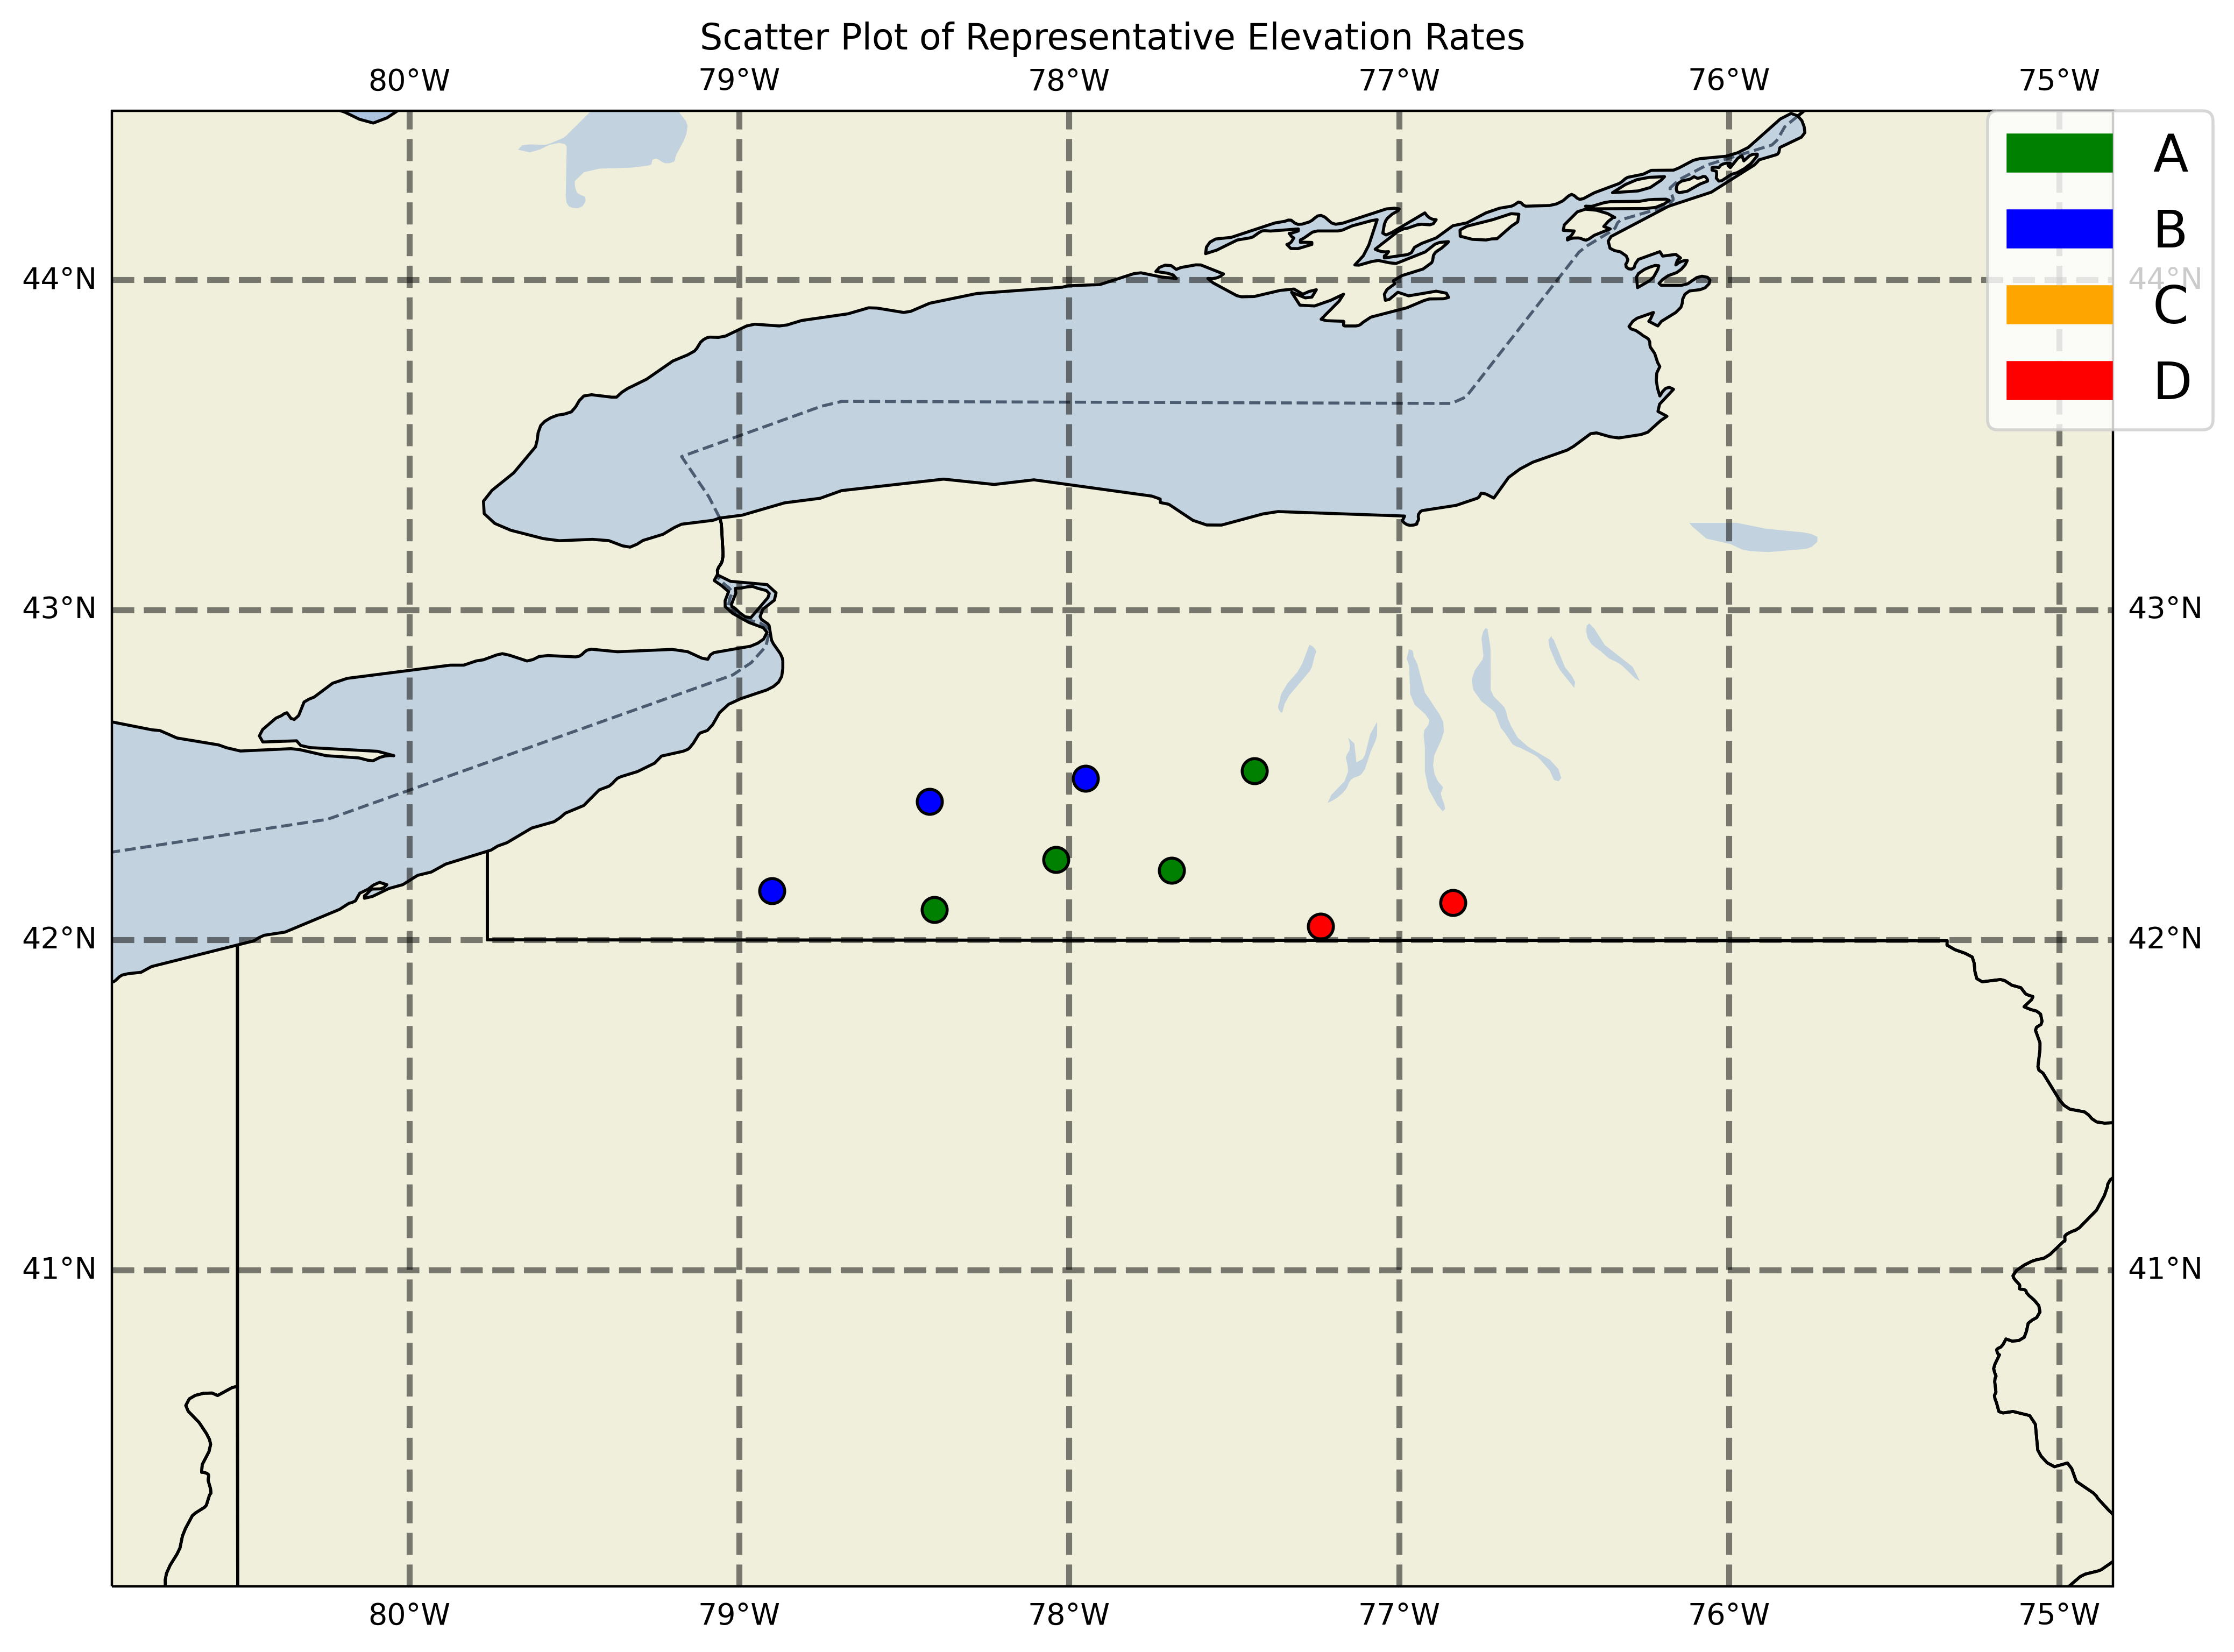

In [14]:
stat_scatterplot_rates(final_df1)

In [15]:
final_df1

finals_1  finals_2  finals_3      sums station    finals        lon  \
0 -1.155350 -1.531570 -1.078540 -3.765460    ADDI -1.791964 -77.237260   
1  0.222124 -0.293759  0.697647  0.626011    BELM  0.297916 -78.039580   
2  0.444724  0.679480 -0.139317  0.984887    COHO  0.468703 -77.437620   
3  0.713466 -0.723029 -1.684875 -1.694439    DELE -0.806375 -78.423200   
4  1.705592 -0.043355  1.695310  3.357546    ELMI  1.597840 -76.836640   
5 -0.636529 -0.453697 -0.376704 -1.466930    GROV -0.698105 -77.949460   
6 -1.596569  1.512197  0.647776  0.563404    HART  0.268121 -77.689733   
7  0.149644 -0.501746  0.001575 -0.350527    OLEA -0.166814 -78.407430   
8  0.152898  1.355480  0.237129  1.745507    RAND  0.830678 -78.900960   

         lat rates        elev  
0  42.040360     D  507.614014  
1  42.242490     A  417.575989  
2  42.511780     A  599.328003  
3  42.418464     B  622.309998  
4  42.113320     D  332.445007  
5  42.489510     B  609.721985  
6  42.211221     A  729.568970  
7  42.091410     A  457.230011  
8  42.149280     B  448.970001

# Climate Division 2

In [16]:
final_df2 = main(2)

LULC


/home/aevans/nwp_bias/src/landtype/notebooks/../src/get_represents.py:12: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Elevation
Aspect/Slope


/home/aevans/nwp_bias/src/landtype/notebooks/../src/get_represents.py:29: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/aevans/nwp_bias/src/landtype/notebooks/../src/get_represents.py:46: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



ANDE
BERK
BROO
CLAR
COBL
DEPO
DUAN
HARP
LAUR
MEDU
MORR
NBRA
OWEG
SHER
SPRI
WALT
WBOU
   station lulc elev aspect_slope
0     ANDE    B    A            C
1     BELD    B    A            B
2     BERK    B    B            A
3     BING    D    B            A
4     BROO    A    A            A
5     CINC    A    B            B
6     CLAR    D    C            C
7     COBL    D    A            A
8     DEPO    A    B            B
9     DUAN    C    A            A
10    ELDR    A    C            B
11    HARP    B    A            A
12    LAUR    A    A            A
13    MEDU    A    A            A
14    MORR    C    C            B
15    NBRA    B    A            A
16    OWEG    B    A            B
17    ROXB    A    D            C
18    SHER    A    A            A
19    SPRI    B    A            B
20    TANN    B    D            D
21    WALT    B    A            B
22    WBOU    C    A            B


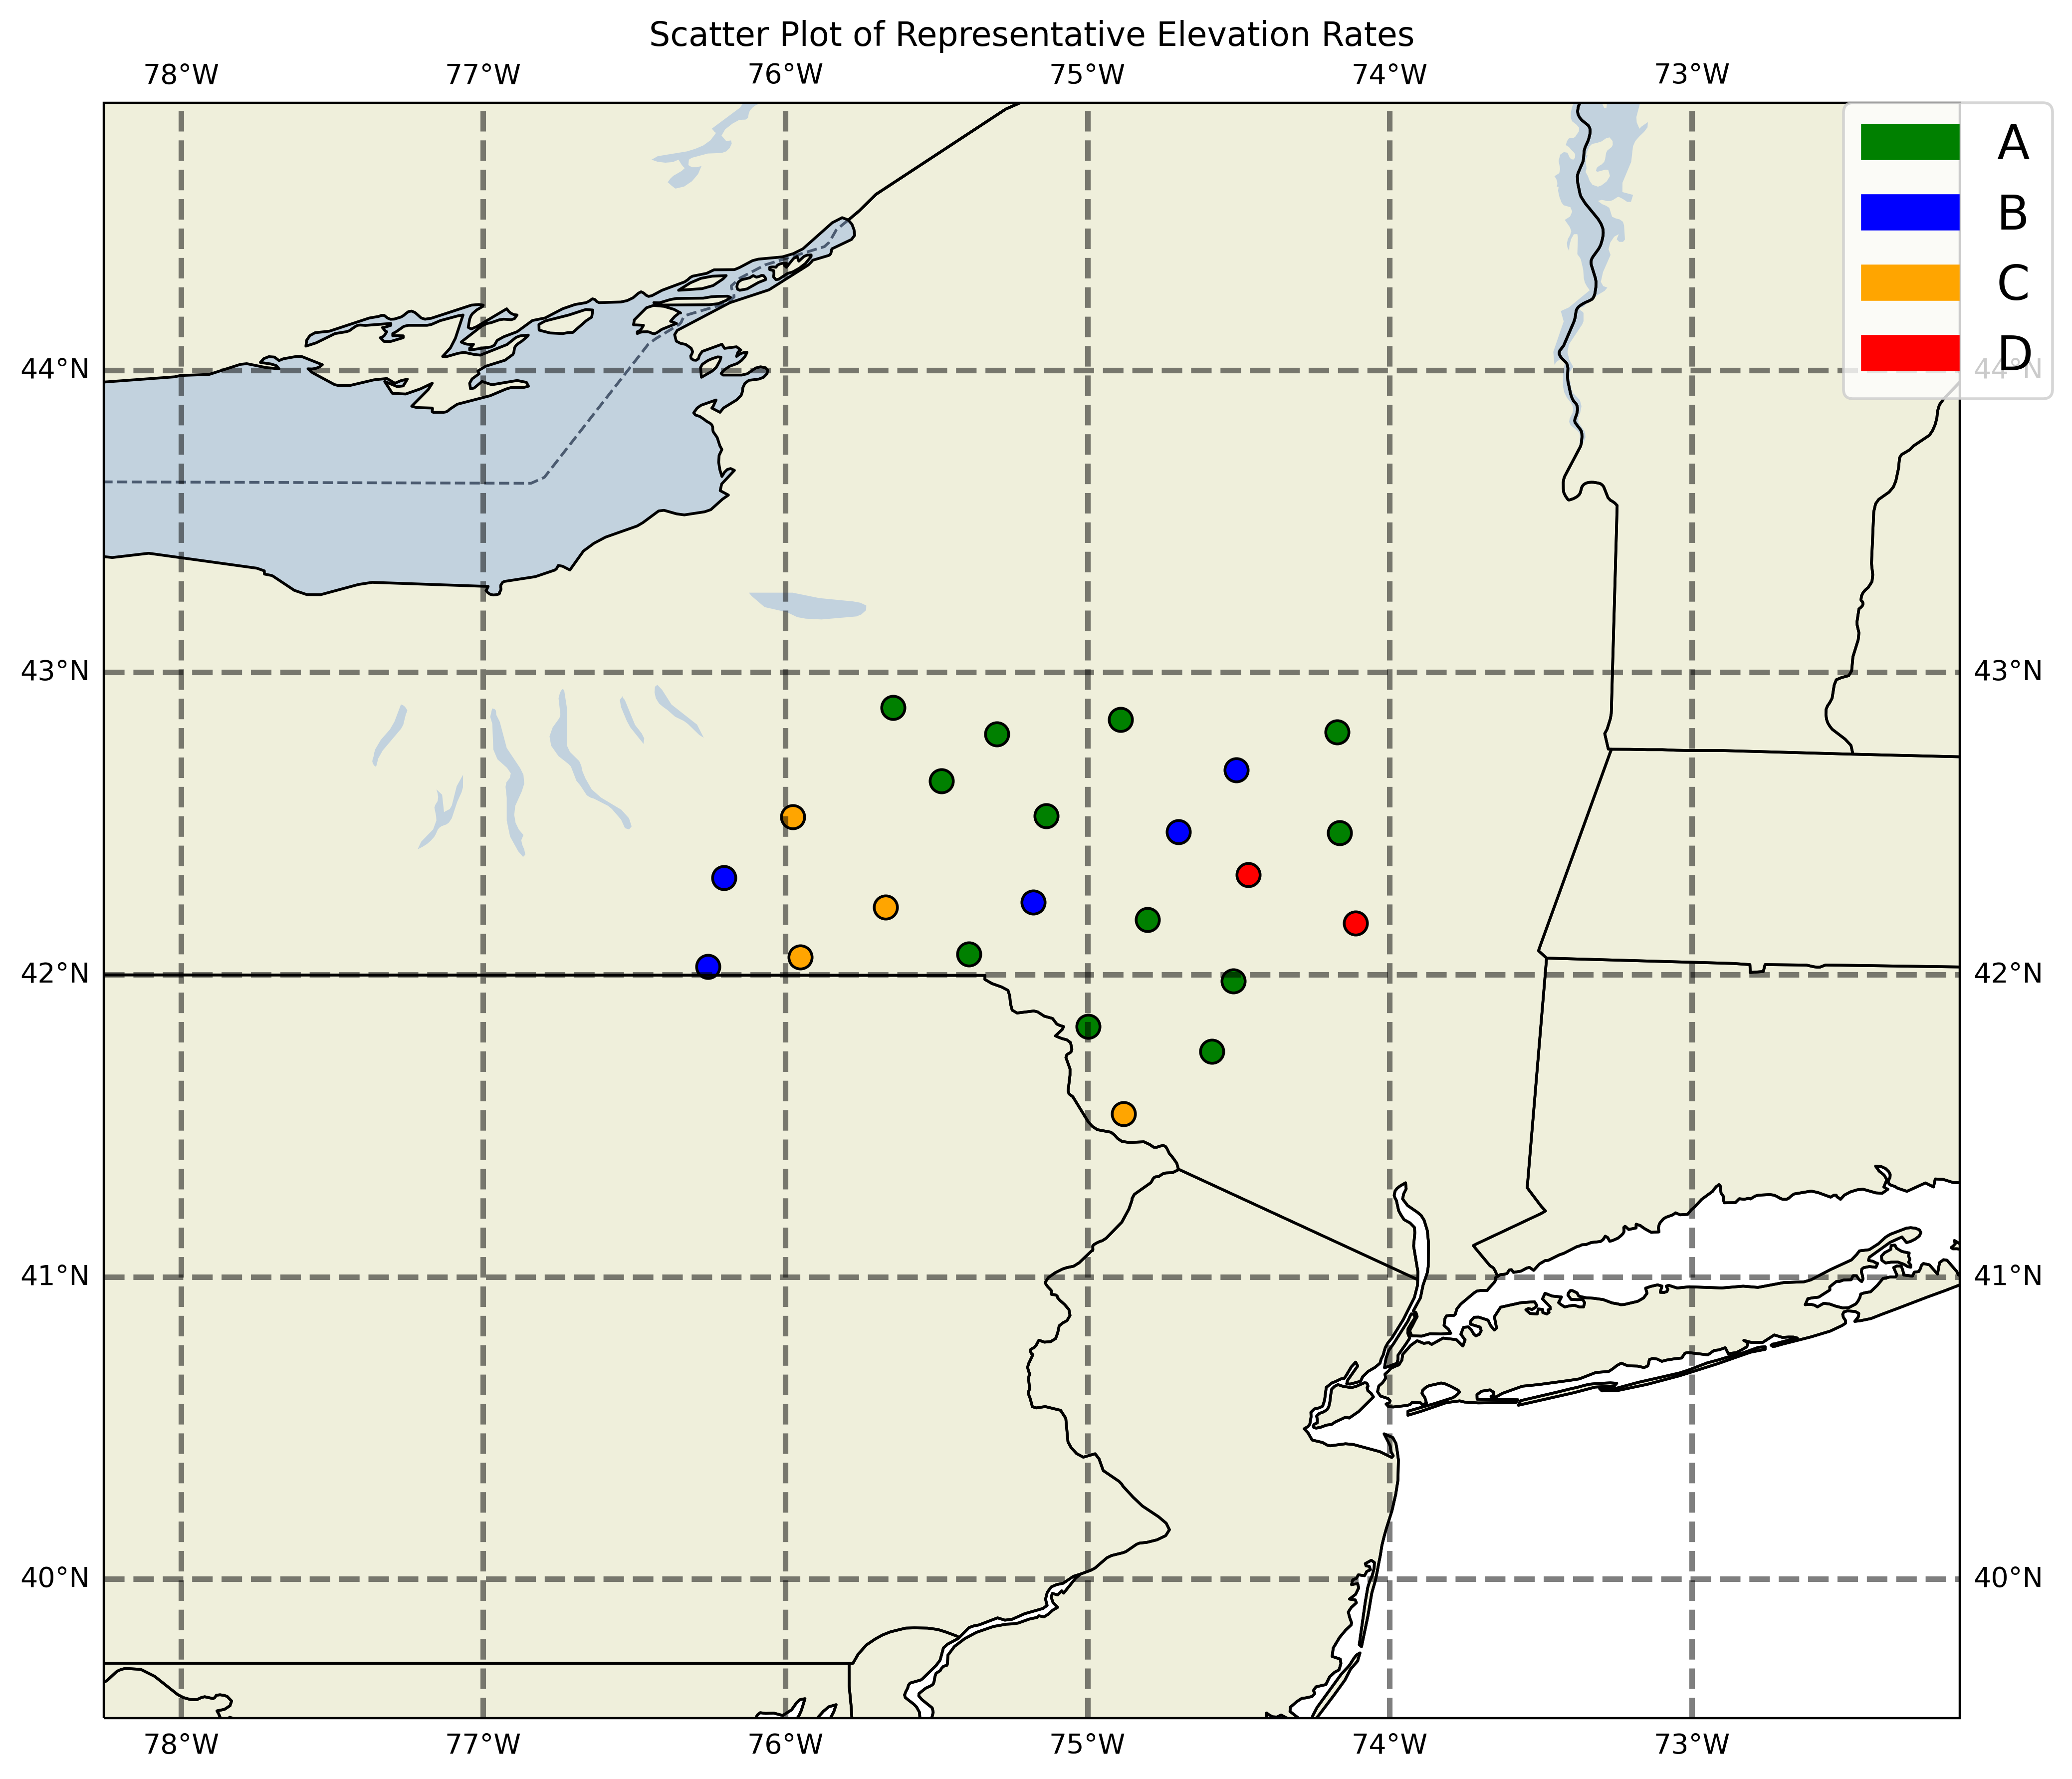

In [17]:
stat_scatterplot_rates(final_df2)

# CLIM DIV 3

In [18]:
final_df3 = main(3)

LULC


/home/aevans/nwp_bias/src/landtype/notebooks/../src/get_represents.py:12: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Elevation
Aspect/Slope


/home/aevans/nwp_bias/src/landtype/notebooks/../src/get_represents.py:29: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/aevans/nwp_bias/src/landtype/notebooks/../src/get_represents.py:46: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
stat_scatterplot_rates(final_df3)

# climdiv 4

In [ ]:
final_df4 = main(4)

In [ ]:
stat_scatterplot_rates(final_df4)

# clim div 5 

In [ ]:
final_df5 = main(5)

In [ ]:
stat_scatterplot_rates(final_df5)

# clim div 6

In [ ]:
final_df6 = main(6)

In [ ]:
stat_scatterplot_rates(final_df6)

# clim div 7

In [ ]:
final_df7 = main(7)

In [ ]:
stat_scatterplot_rates(final_df7)

# clim div 8 

In [ ]:
final_df8 = main(8)

In [ ]:
stat_scatterplot_rates(final_df8)

# clim div 9

In [ ]:
final_df9 = main(9)

In [ ]:
stat_scatterplot_rates(final_df9)

# clim div 10

In [ ]:
final_df10 = main(10)

In [ ]:
stat_scatterplot_rates(final_df10)